In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge


# Overview

In this notebook, we will try linear regression with kernel transformation and regularization

## Report Metrics
sample weighted zero-mean R-squared score (R2) of responder_6:
$ R^2 = 1 - \frac{\sum w_i (y_i - \hat{y}_i)^2}{\sum w_i y_i^2}$

## Kernel Used
1. Polynomila Kernels
2. RBF Kernels

## Other Transformation Method
PCA

## Regularization
We used Ridge Regularization with RBF Kernel and with PCA.

# Load Data and Split

In [2]:
df = pd.read_csv("df_miss_outliers_replaced_scaled_normalized.csv")

In [3]:
features = df[[f"feature_{i:02}" for i in range(79)]]
target = df['responder_6']

## Split the dataset into training (80%) and validation (20%) sets

In [4]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

## Polynomial Kernel + Linear Regression

In [ ]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)  # You can adjust the degree
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)


In [ ]:
# Fit Linear Regression
model = LinearRegression()
model.fit(X_train_poly, y_train)


LinearRegression()

### Validation Metrics

In [ ]:
# Predict on validation set
y_pred = model.predict(X_val_poly)

weights_val = df.loc[y_val.index, 'weight']

In [ ]:
# Calculate zero-mean R2
y_val_mean_adjusted = y_val - np.mean(y_val)
y_pred_mean_adjusted = y_pred - np.mean(y_pred)
weighted_r2 = r2_score(y_val_mean_adjusted, y_pred_mean_adjusted, sample_weight=weights_val)

print(f"Weighted zero-mean R^2 score: {weighted_r2}")

Weighted zero-mean R^2 score: -0.004138794607616347


## Linear Regression without Kernel

In [ ]:
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression()

### Training Metrics

In [ ]:
# Predict on the training set
y_train_pred = model2.predict(X_train)

# Calculate zero-mean R2
weights_train = df.loc[y_train.index, 'weight']
y_train_mean_adjusted = y_train - np.mean(y_train)
y_train_pred_mean_adjusted = y_train_pred - np.mean(y_train_pred)
weighted_r2 = r2_score(y_train_mean_adjusted, y_train_pred_mean_adjusted, sample_weight=weights_train)

print(f"Weighted zero-mean R^2 score: {weighted_r2}")

Weighted zero-mean R^2 score: 0.005169046045009118


### Validation Metrics

In [ ]:
# Predict on validation set
y_pred = model2.predict(X_val)

weights_val = df.loc[y_val.index, 'weight']

In [ ]:
# Calculate zero-mean R2
y_val_mean_adjusted = y_val - np.mean(y_val)
y_pred_mean_adjusted = y_pred - np.mean(y_pred)
weighted_r2 = r2_score(y_val_mean_adjusted, y_pred_mean_adjusted, sample_weight=weights_val)

print(f"Weighted zero-mean R^2 score: {weighted_r2}")

Weighted zero-mean R^2 score: 0.004647004363416918


## Summary

The negative R-square of regression with polynomila kernel indicates that out model's performance is slightly worse than simply predicting the mean of the target variable for all observations.

The model does not fit the data well. It's not capturing the variance in the target variable effectively. We will try other method of feature transformation later.

One possible reason is that the model is overfitting because after the . We will add regularizaions later.

We might consider selecting a subset of the most informative features or performing feature engineering to derive new features that better capture the relationships in the data.

## RBF Kernel + Linear Regression + Regularization

We tried RBF Kernel. But my computer kernel always stops and we have not enough computational power to try RBF Kernel. Thus, I resample the data again to cut the size.

In [ ]:
small_df = df.groupby('date_id').sample(frac = 0.1).reset_index(drop=True)

In [ ]:
features_s = small_df[[f"feature_{i:02}" for i in range(79)]]
target_s = small_df['responder_6']

In [ ]:
alphas = [0.1, 0.5, 1.0, 5, 10, 100, 1000, 10000]
training_r2_scores = []
validation_r2_scores = []

In [ ]:
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(features_s, target_s, test_size=0.2, random_state=42)

In [ ]:
for alpha in alphas:
    # Create the Kernel Ridge Regression model
    krr = KernelRidge(alpha=alpha, kernel='rbf')

    # Fit the model on the training data
    krr.fit(X_train_s, y_train_s)

    # Calculate the training R^2 score
    training_r2 = krr.score(X_train_s, y_train_s)
    training_r2_scores.append(training_r2)

    # Calculate the validation R^2 score
    validation_r2 = krr.score(X_val_s, y_val_s)
    validation_r2_scores.append(validation_r2)

In [ ]:
training_r2_scores

[0.02028360077926905,
 0.01136098620102366,
 0.009592861359291383,
 0.007052100092531544,
 0.005927682689489289,
 0.0018601512315888913,
 0.000270842785747738,
 2.877759926278589e-05]

In [ ]:
validation_r2_scores

[0.0009565291051248925,
 0.0008854032613194729,
 0.0010282174795011034,
 0.0018176982207458448,
 0.001963695100611673,
 0.0007685488526061324,
 -3.317062165208995e-05,
 -0.00017040520210276355]

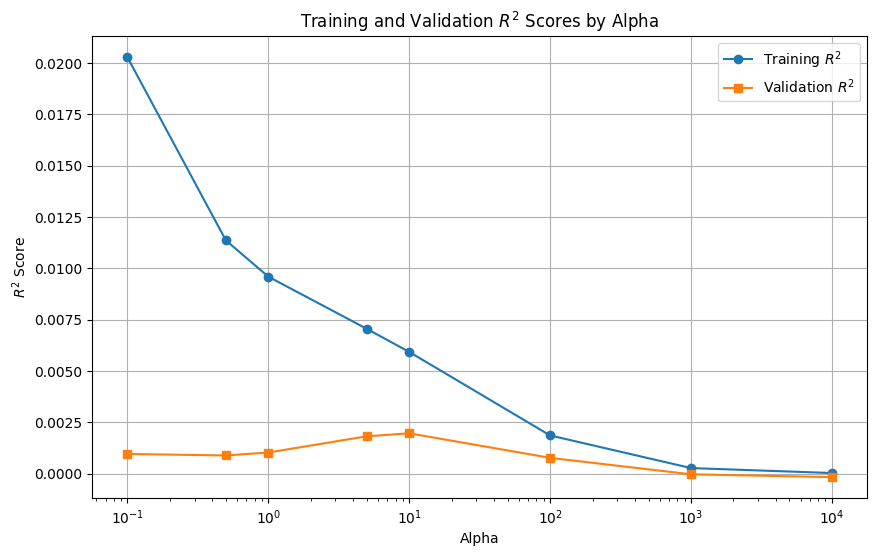

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, training_r2_scores, marker='o', label='Training $R^2$')
plt.plot(alphas, validation_r2_scores, marker='s', label='Validation $R^2$')
plt.xscale('log')  # Setting x-axis to logarithmic scale due to wide range of alphas
plt.xlabel('Alpha')
plt.ylabel('$R^2$ Score')
plt.title('Training and Validation $R^2$ Scores by Alpha')
plt.legend()
plt.grid(True)
plt.show()

# Summary

We can see that RBF Kernel with Ridge Regression definitely have a better performance than polynomial kernel. With alpha values we tried, we can observe an overfitting at first and the best alpha value is 10. However, we always get a under fitting result so we need to have more complex method to catch the trend of the data

## PCA + Linear Regression + Regularizaiton

In [21]:
pca = PCA(n_components='mle')  # 'mle' automatically selects the number of components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [22]:
alphas = [0.01, 0.1, 0.5, 1.0, 5, 10, 100, 1000, 10000]

In [23]:
train_r2_scores = []
val_r2_scores = []

# Loop over alpha values to train and evaluate the Ridge model
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_pca, y_train)
    train_r2 = r2_score(y_train, ridge.predict(X_train_pca))
    val_r2 = r2_score(y_val, ridge.predict(X_val_pca))
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    print(f"Alpha: {alpha:.4f} -> Training R^2: {train_r2:.3f}, Validation R^2: {val_r2:.3f}")


Alpha: 0.0100 -> Training R^2: 0.007, Validation R^2: 0.006
Alpha: 0.1000 -> Training R^2: 0.007, Validation R^2: 0.006
Alpha: 0.5000 -> Training R^2: 0.007, Validation R^2: 0.006
Alpha: 1.0000 -> Training R^2: 0.007, Validation R^2: 0.006
Alpha: 5.0000 -> Training R^2: 0.007, Validation R^2: 0.006
Alpha: 10.0000 -> Training R^2: 0.007, Validation R^2: 0.006
Alpha: 100.0000 -> Training R^2: 0.007, Validation R^2: 0.006
Alpha: 1000.0000 -> Training R^2: 0.005, Validation R^2: 0.005
Alpha: 10000.0000 -> Training R^2: 0.002, Validation R^2: 0.002


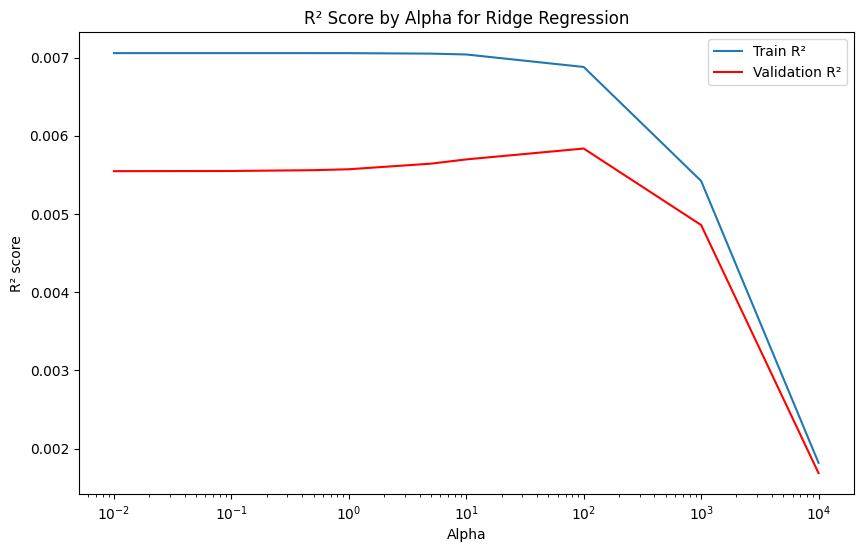

In [24]:
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, train_r2_scores, label='Train R²')
plt.semilogx(alphas, val_r2_scores, color='red', label='Validation R²')
plt.xlabel('Alpha')
plt.ylabel('R² score')
plt.title('R² Score by Alpha for Ridge Regression')
plt.legend()
plt.show()

In [18]:
len(pca.explained_variance_)

77

In [20]:
for i in range(1,78):
  print("# of components:", i)
  print("--------")
  pca = PCA(n_components= i)  # 'mle' automatically selects the number of components
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)

  train_r2_scores = []
  val_r2_scores = []

  for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_pca, y_train)
    train_r2 = r2_score(y_train, ridge.predict(X_train_pca))
    val_r2 = r2_score(y_val, ridge.predict(X_val_pca))
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    print(f"Alpha: {alpha:.4f} -> Training R^2: {train_r2:.3f}, Validation R^2: {val_r2:.3f}")

# of components: 1
--------
Alpha: 0.0100 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 0.1000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 0.5000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 1.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 5.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 10.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 100.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 1000.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 10000.0000 -> Training R^2: 0.000, Validation R^2: 0.000
# of components: 2
--------
Alpha: 0.0100 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 0.1000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 0.5000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 1.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 5.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 10.0000 -> Training R^2: 0.000, Validation R^2: 0.000
Alpha: 100.0000 -> Training R^2: 

## Summary

We observed that PCA with 46 components and regularization alpha of 100 will give the best result.

It performs better than RBF Kernel with regularization but overall still underfitting.